# Préparation des données

In [46]:
import pandas as pd
import numpy as np
import random

# Load the dataset
url = "https://www.data.gouv.fr/fr/datasets/r/78348f03-a11c-4a6b-b8db-2acf4fee81b1"
dtypes = {
    'Date mutation': 'str',
    'Nature mutation': 'str',
    'Valeur fonciere': 'float',
    'Code postal': 'str',
    'Commune': 'str',
    'Code departement': 'str',
    'Code commune': 'str',
    'Type local': 'str',
    'Surface reelle bati': 'float',
    'Nombre pieces principales': 'Int64',
    'Surface terrain': 'float',
    'Nature culture': 'str',
    'Nature culture speciale': 'str'
}
#df = pd.read_csv(url, delimiter='|', decimal=",", na_values=[''], skiprows=lambda i: i>0 and random.random() > 0.2)
df = pd.read_csv(url, delimiter='|', decimal=",", na_values=[''])
df['Nature culture'] = df['Nature culture'].fillna("NaN")
df['Nature culture speciale'] = df['Nature culture speciale'].fillna("NaN")
df['Type local'] = df['Type local'].fillna("NaN")
#df['Surface reelle bati'] = df['Surface reelle bati'].fillna(df['Surface reelle bati'].mean())
df['Nombre pieces principales'] = df['Nombre pieces principales'].fillna(df['Nombre pieces principales'].mean().round())
#df['Surface terrain'] = df['Surface terrain'].fillna(df['Surface terrain'].mean())

df = df.astype(dtypes)

# Convertir 'Date mutation' en mois (float)
df['Date mutation'] = pd.to_datetime(df['Date mutation'], format='%d/%m/%Y')
df['Date mutation'] = df['Date mutation'].dt.month

print(df.head())
print(df.dtypes)

<ipython-input-46-1294b54fbf5c>:23: DtypeWarning:

Columns (14,18,23,24,26,28,32,41) have mixed types. Specify dtype option on import or set low_memory=False.



   Identifiant de document  Reference document  1 Articles CGI  \
0                      NaN                 NaN             NaN   
1                      NaN                 NaN             NaN   
2                      NaN                 NaN             NaN   
3                      NaN                 NaN             NaN   
4                      NaN                 NaN             NaN   

   2 Articles CGI  3 Articles CGI  4 Articles CGI  5 Articles CGI  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   No disposition  Date mutation Nature mutation  ...  \
0               1              1           Vente  ...   
1               1              1           Vente  ...   
2               1

In [47]:
# Garder les colonnes pertinentes
columns_to_keep = [
    'Date mutation', 'Nature mutation', 'Valeur fonciere', 'Code postal',
    'Code departement', 'Type local',
    'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain',
]
df = df[columns_to_keep]

df = df.dropna(subset=['Valeur fonciere', 'Code postal', 'Surface reelle bati', 'Surface terrain'])
df = df[df['Valeur fonciere']>10]
df = df[df['Valeur fonciere']<5000000]
df = df[df['Surface reelle bati']<100000]
df = df[df['Surface terrain']<400000]
df = df[df['Nombre pieces principales']<40]

print(df.head())

   Date mutation Nature mutation  Valeur fonciere Code postal  \
3              1           Vente         152200.0      1450.0   
4              1           Vente         269000.0      1800.0   
5              1           Vente         269000.0      1800.0   
6              1           Vente         269000.0      1800.0   
7              1           Vente         770000.0      1210.0   

  Code departement  Type local  Surface reelle bati  \
3                1      Maison                 64.0   
4                1      Maison                 73.0   
5                1  Dépendance                  0.0   
6                1  Dépendance                  0.0   
7                1      Maison                136.0   

   Nombre pieces principales  Surface terrain  
3                          3            988.0  
4                          3            835.0  
5                          0            835.0  
6                          0            835.0  
7                          7          

# Partie Analyse Exploratoire Des Données

In [48]:
print(df.dtypes)

Date mutation                  int32
Nature mutation               object
Valeur fonciere              float64
Code postal                   object
Code departement              object
Type local                    object
Surface reelle bati          float64
Nombre pieces principales      Int64
Surface terrain              float64
dtype: object


In [49]:
print(df.head())

   Date mutation Nature mutation  Valeur fonciere Code postal  \
3              1           Vente         152200.0      1450.0   
4              1           Vente         269000.0      1800.0   
5              1           Vente         269000.0      1800.0   
6              1           Vente         269000.0      1800.0   
7              1           Vente         770000.0      1210.0   

  Code departement  Type local  Surface reelle bati  \
3                1      Maison                 64.0   
4                1      Maison                 73.0   
5                1  Dépendance                  0.0   
6                1  Dépendance                  0.0   
7                1      Maison                136.0   

   Nombre pieces principales  Surface terrain  
3                          3            988.0  
4                          3            835.0  
5                          0            835.0  
6                          0            835.0  
7                          7          

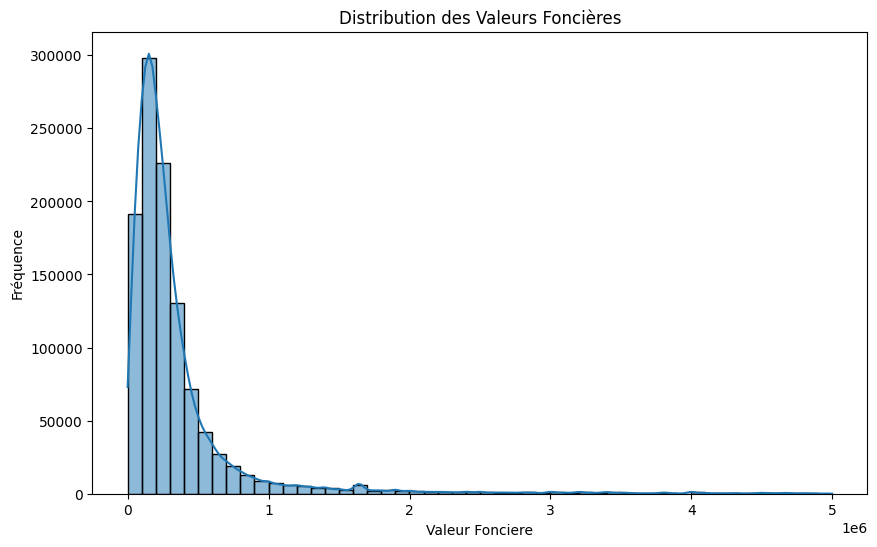

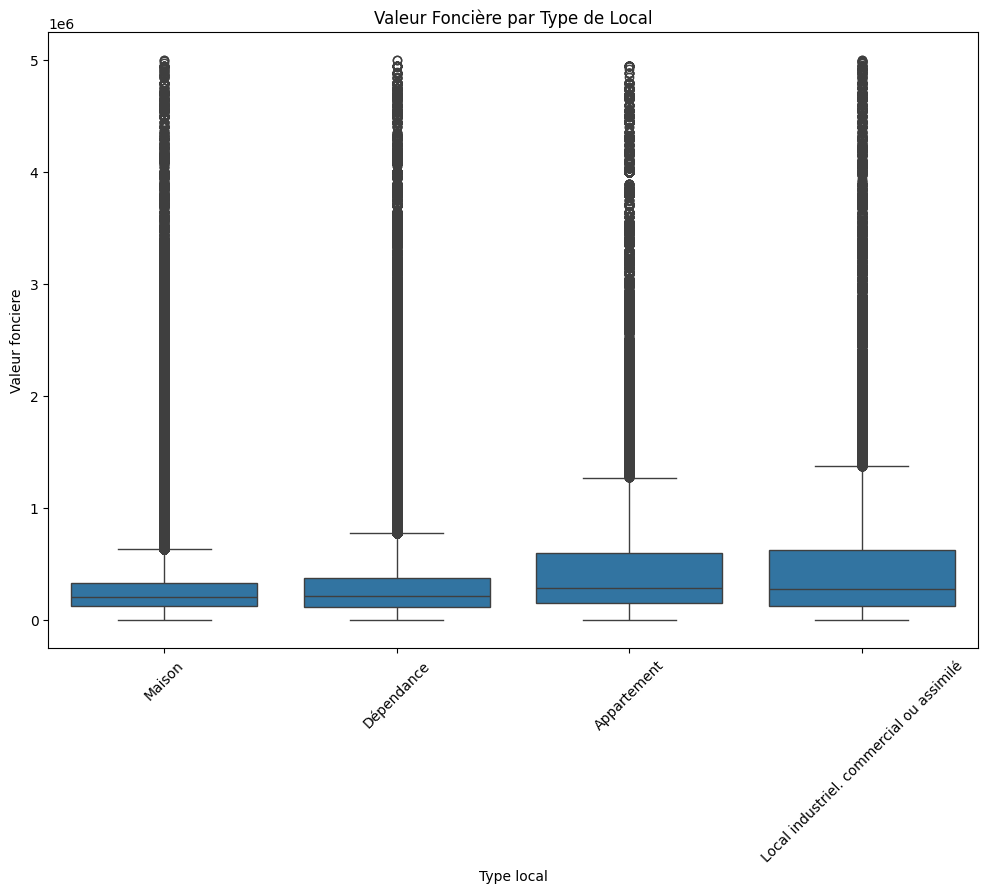

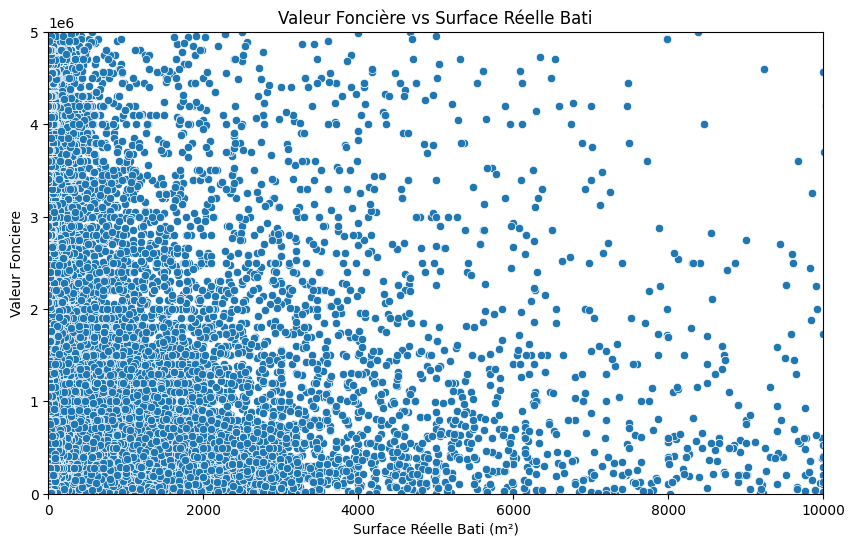

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogramme des valeurs foncières
plt.figure(figsize=(10, 6))
sns.histplot(df['Valeur fonciere'], bins=50, kde=True)
plt.title('Distribution des Valeurs Foncières')
plt.xlabel('Valeur Fonciere')
plt.ylabel('Fréquence')
plt.show()

# Boxplot des valeurs foncières par type de location
plt.figure(figsize=(12, 8))
sns.boxplot(x='Type local', y='Valeur fonciere', data=df)
plt.title('Valeur Foncière par Type de Local')
plt.xticks(rotation=45)
plt.show()

# Scatterplot Valeur foncière vs Surface réelle bâti
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Surface reelle bati', y='Valeur fonciere', data=df)
plt.title('Valeur Foncière vs Surface Réelle Bati')
plt.xlabel('Surface Réelle Bati (m²)')
plt.ylabel('Valeur Fonciere')
plt.ylim(0, 5000000)
plt.xlim(0, 10000)
plt.show()


## Geomap

In [51]:
import geopandas as gpd
import plotly.express as px


# Feature engineering
df = df[df['Surface reelle bati'] > 0]

df['Prix_m2'] = df['Valeur fonciere'] / df['Surface reelle bati']

# Filtrer les valeurs aberrantes
df = df[df['Prix_m2'] < 30000]

prix_m2_par_departement = df.groupby('Code departement')['Prix_m2'].mean().reset_index()
prix_m2_par_departement.columns = ['code', 'Prix_m2']

# Convertir le code département en string pour correspondre au geojson
prix_m2_par_departement['code'] = prix_m2_par_departement['code'].str.zfill(2)

# Formater les prix avec séparateurs de milliers et le symbole €
prix_m2_par_departement['Prix_m2_format'] = prix_m2_par_departement['Prix_m2'].apply(lambda x: f"{x:,.2f} €".replace(',', ' ').replace('.', ','))

# Geomap
geojson_url = 'https://france-geojson.gregoiredavid.fr/repo/departements.geojson'
departements_geojson = gpd.read_file(geojson_url)

# Créer la carte
fig = px.choropleth_mapbox(
    prix_m2_par_departement,
    geojson=departements_geojson,
    featureidkey="properties.code",
    locations='code',
    color='Prix_m2',
    color_continuous_scale="Viridis",
    mapbox_style="carto-positron",
    zoom=5,
    center={"lat": 46.603354, "lon": 1.888334},
    opacity=0.6,
    labels={'Prix_m2': 'Prix moyen par m²'},
    title='Prix moyen par m² par département',
    hover_data={'Prix_m2_format': True, 'Prix_m2': False}  # Utiliser la colonne formatée pour l'affichage
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<ipython-input-51-ec573c3e490e>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Histogramme

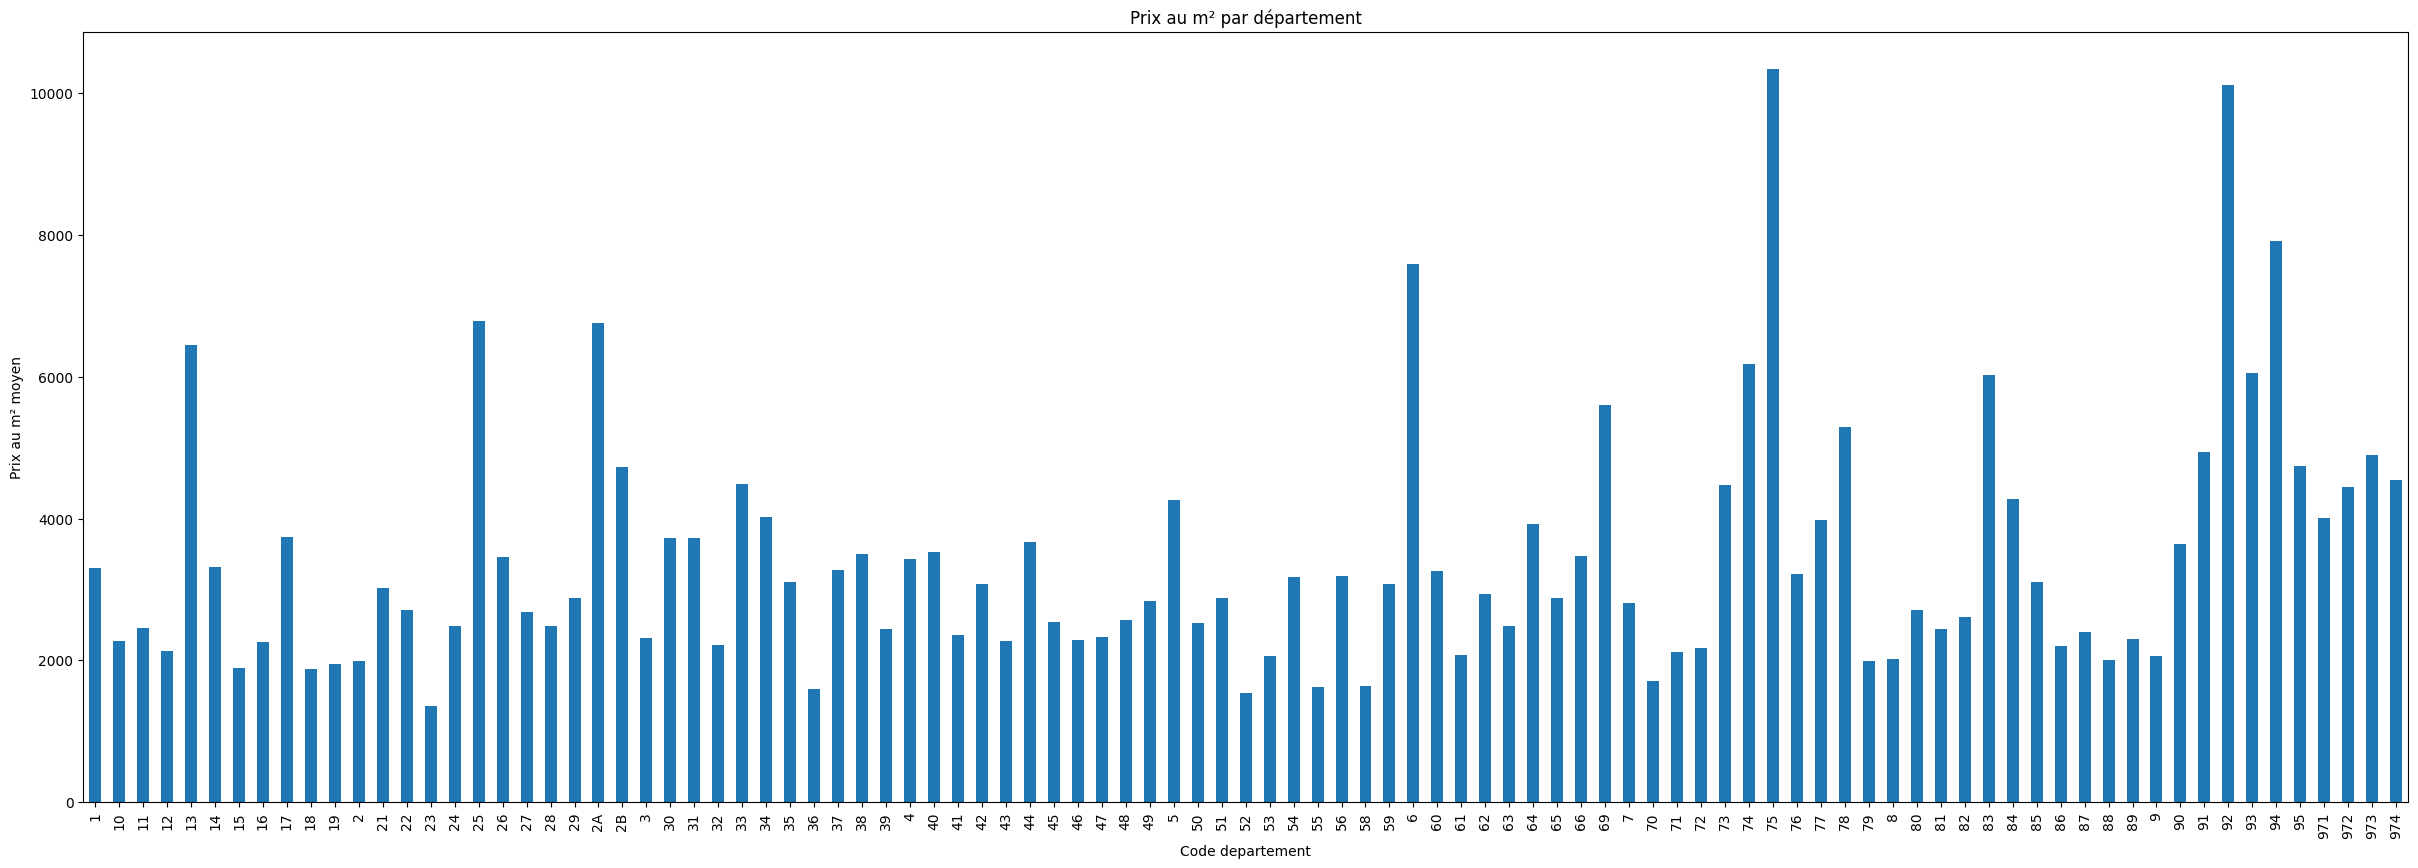

In [52]:
df.groupby('Code departement')['Prix_m2'].mean().plot(kind='bar', figsize=(30, 10))
plt.ylabel('Prix au m² moyen')
plt.title('Prix au m² par département')
plt.show()

## Encodage des Variables Catégorielles

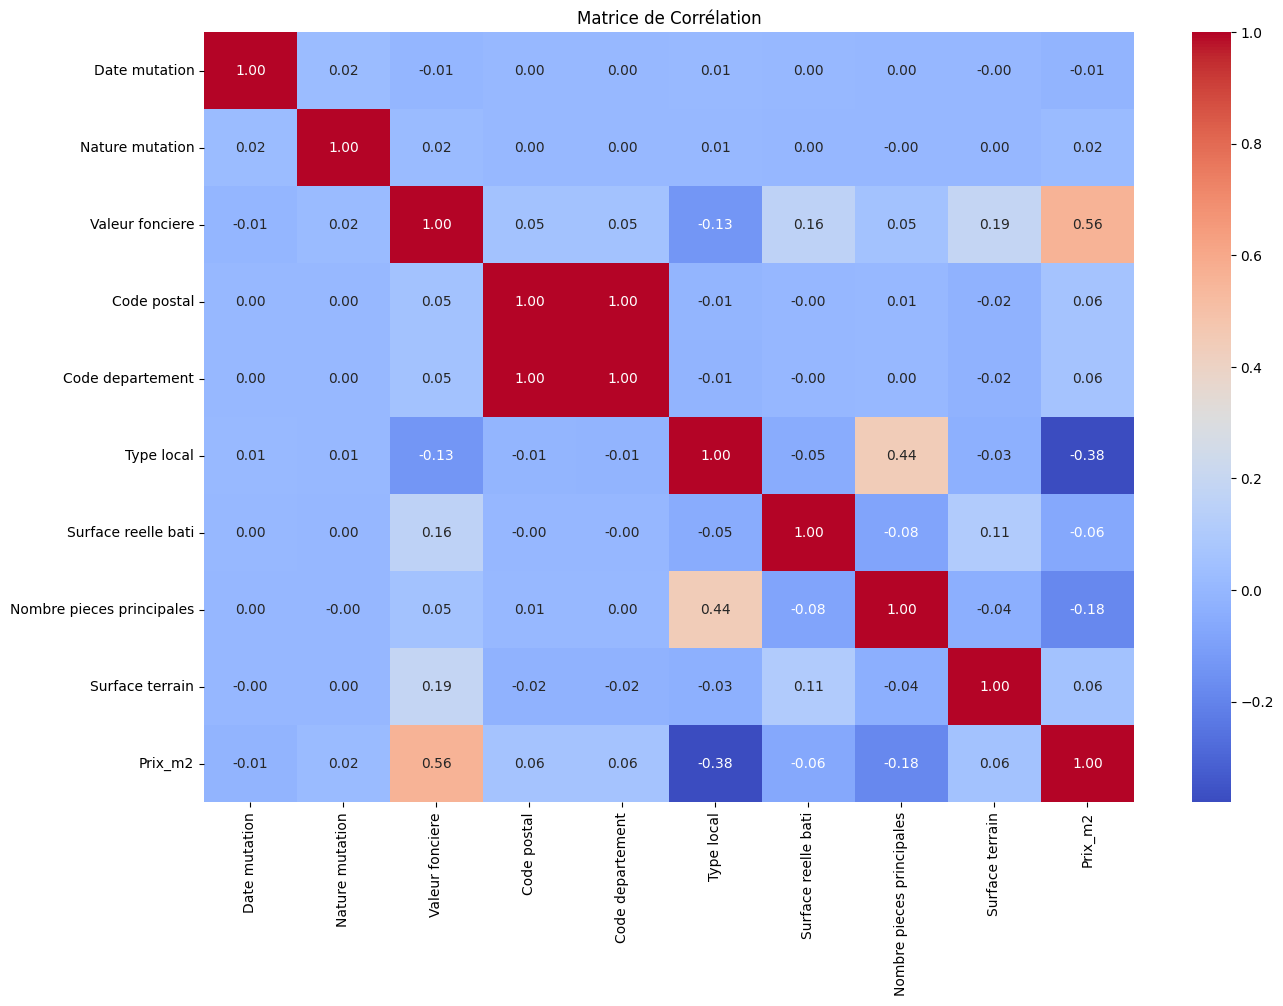

In [53]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Encoder les colonnes catégorielles en utilisant LabelEncoder
label_encoders = {}
df_encoded = df.copy()
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#standardiser
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.set_output(transform='pandas')
df_scaled = scaler.fit_transform(df_encoded)

#Matrice de corrélation
correlation_matrix = df_scaled.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de Corrélation')
plt.show()


## Scatter matrix

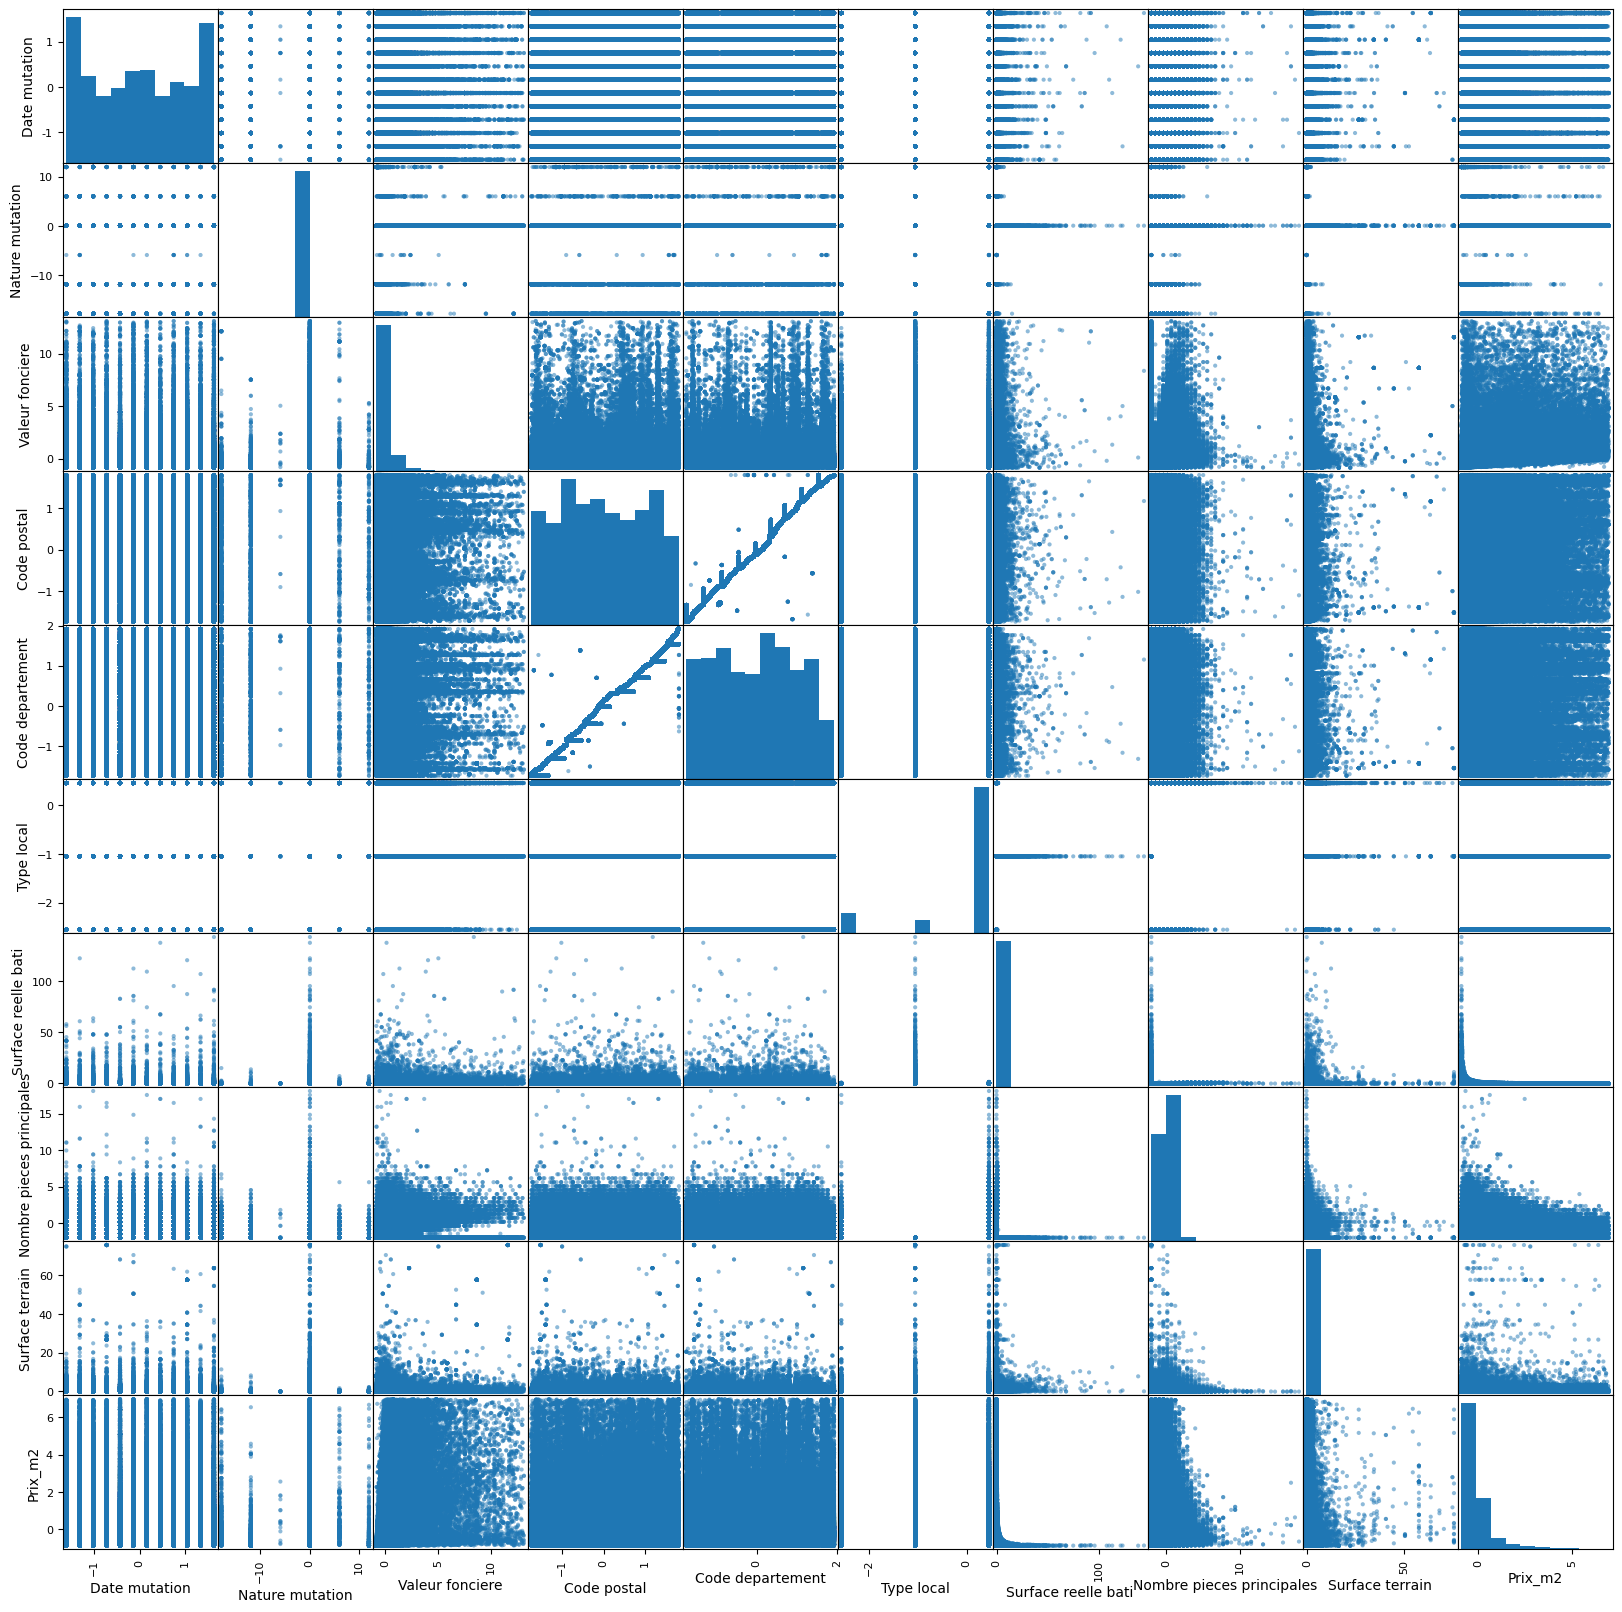

In [55]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_scaled, figsize=[20, 20])
plt.show()

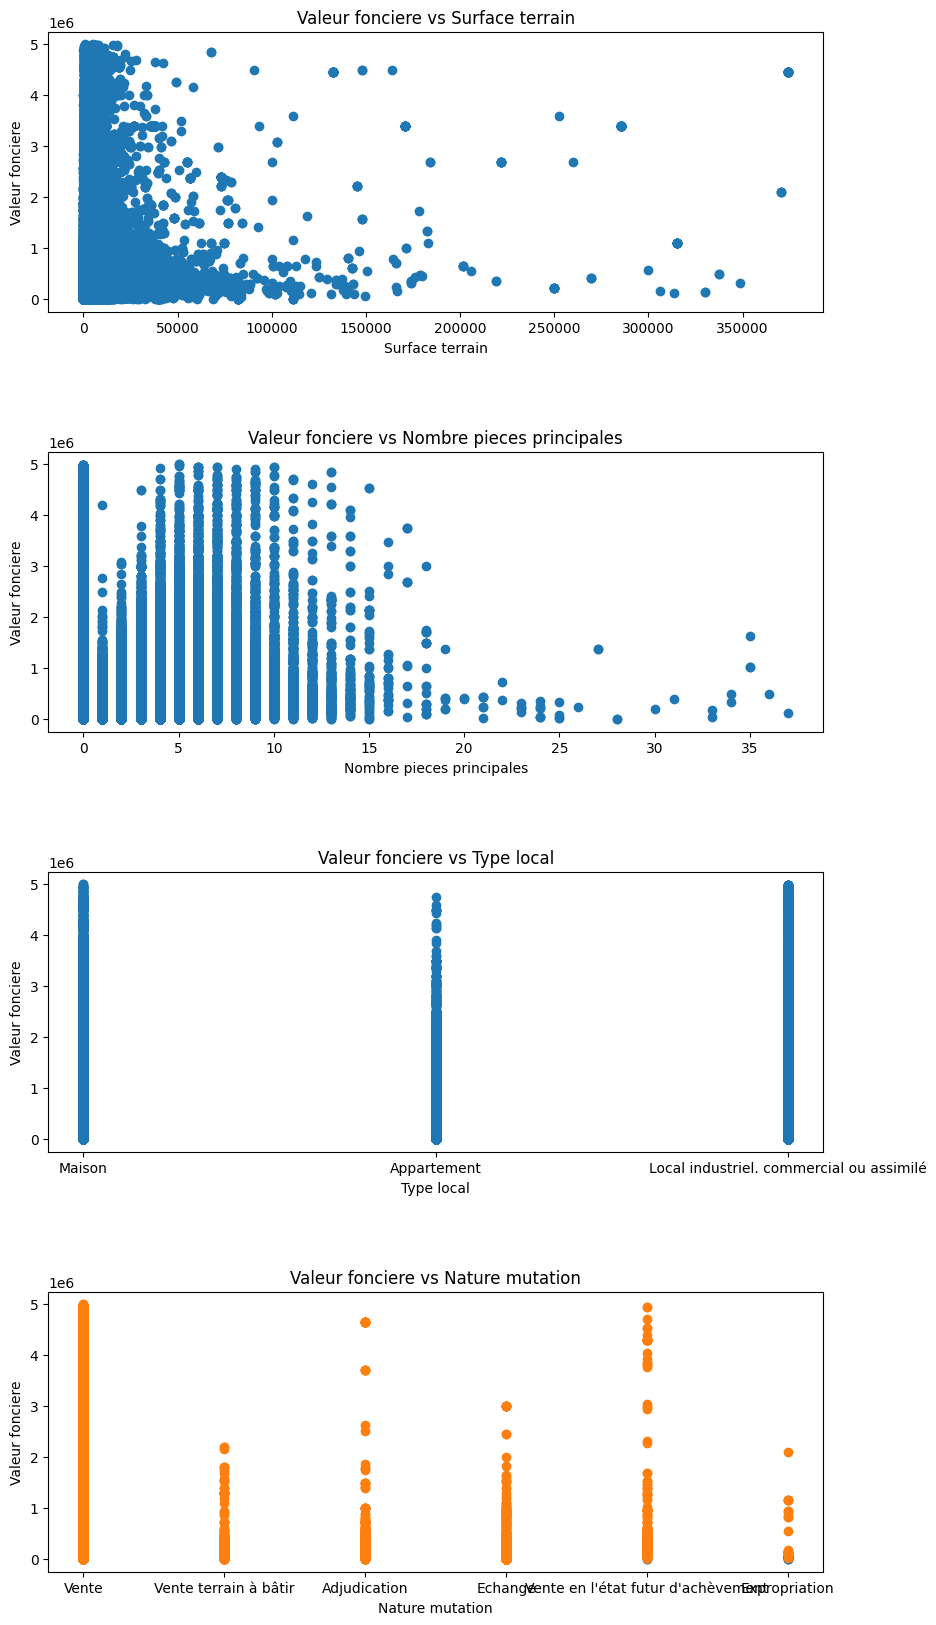

In [56]:
columns_to_keep = ['Surface reelle bati', 'Surface terrain', 'Nombre pieces principales', 'Type local', 'Nature mutation']

fig, axes = plt.subplots(nrows=len(columns_to_keep) - 1, ncols=1, figsize=(10, len(columns_to_keep) * 4))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(columns_to_keep):
    if col != 'Valeur fonciere':
        ax = axes[i - 1]
        ax.scatter(df[col], df['Valeur fonciere'])
        ax.set_ylabel('Valeur fonciere')
        ax.set_xlabel(col)
        ax.set_title(f'Valeur fonciere vs {col}')

plt.show()

# Partie Modeles Machine Learning

## Apprentissage non supervisé

## Méthode du coude

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

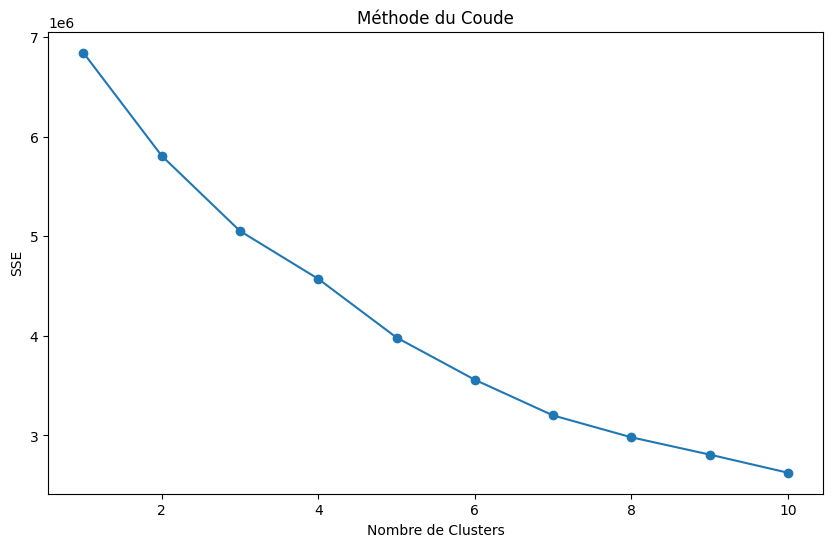

In [57]:
from sklearn.cluster import KMeans
# Méthode du coude pour déterminer le nombre optimal de clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Nombre de Clusters')
plt.ylabel('SSE')
plt.title('Méthode du Coude')
plt.show()

## KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



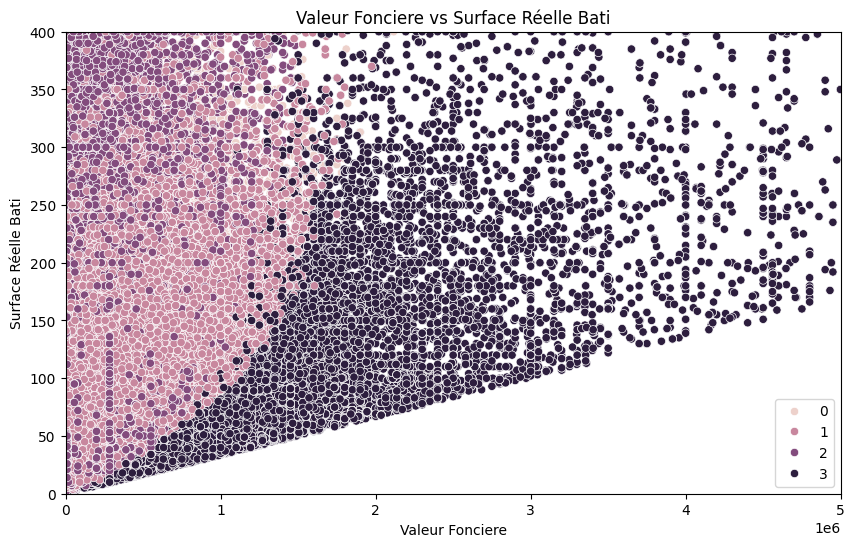

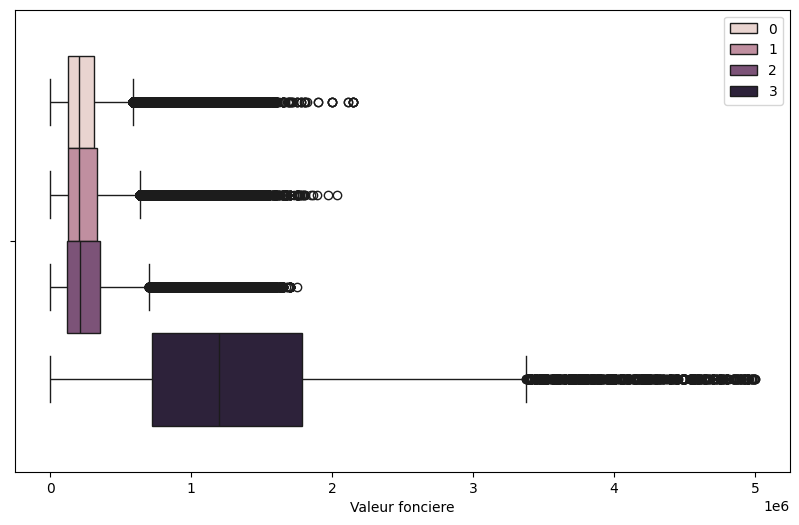

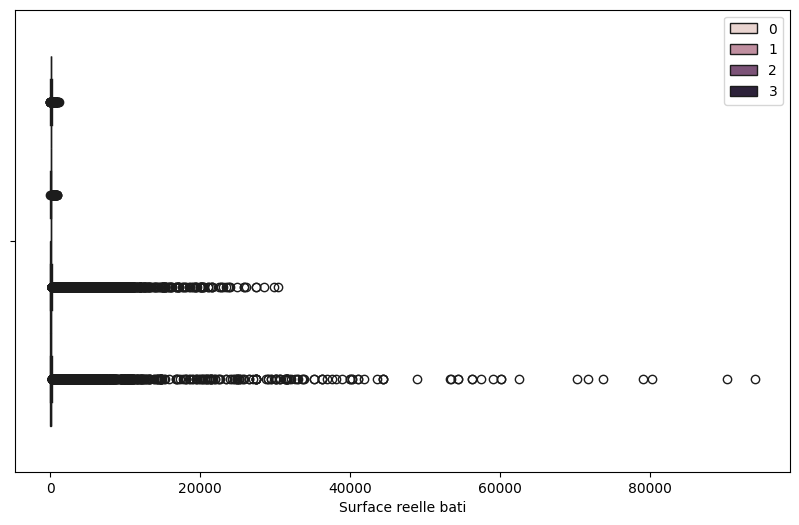

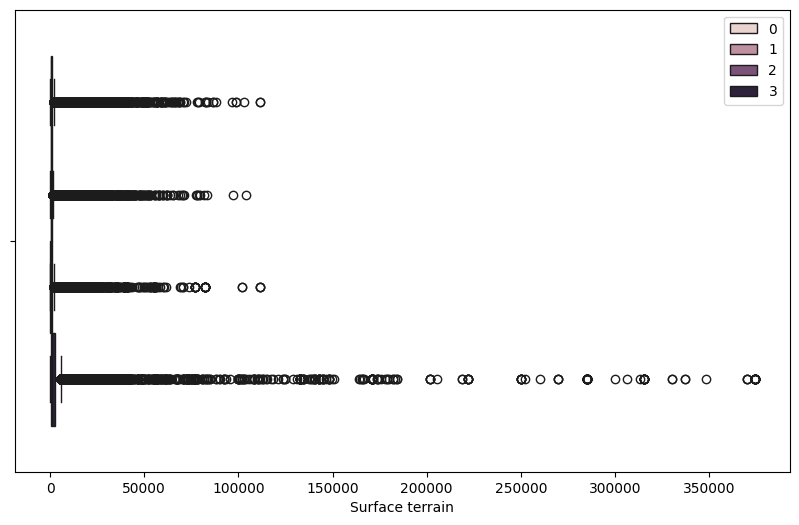

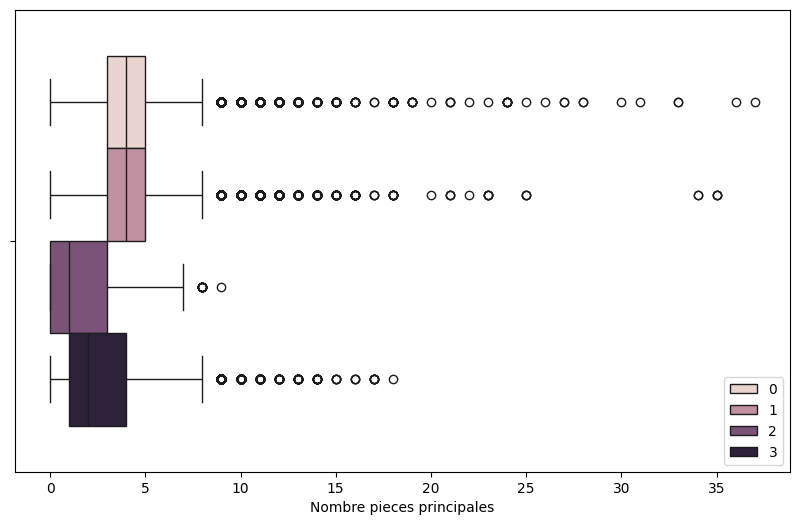

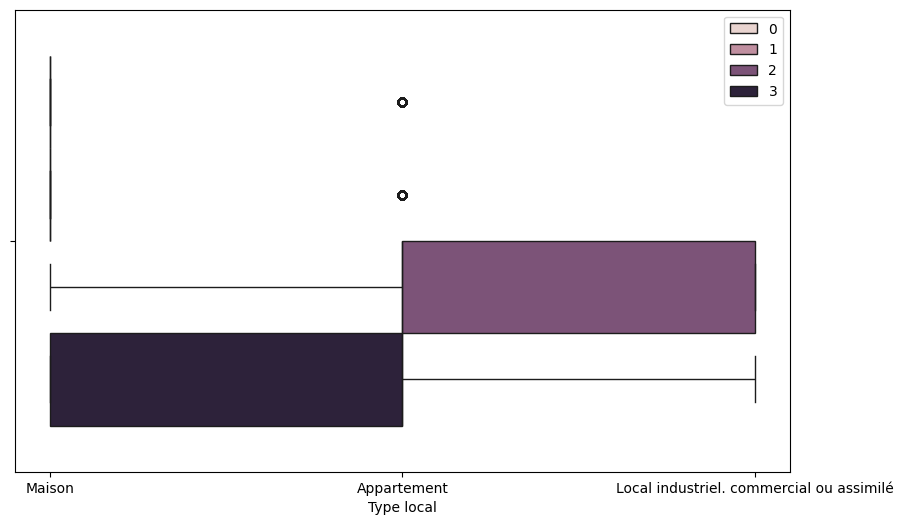

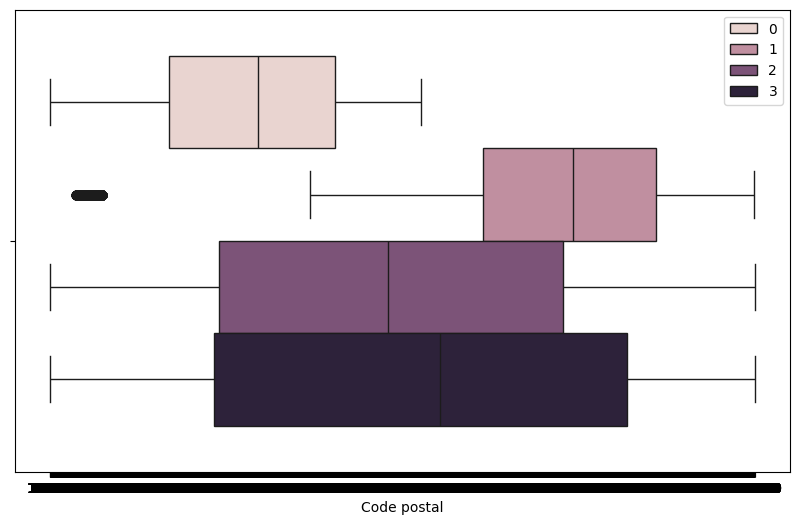

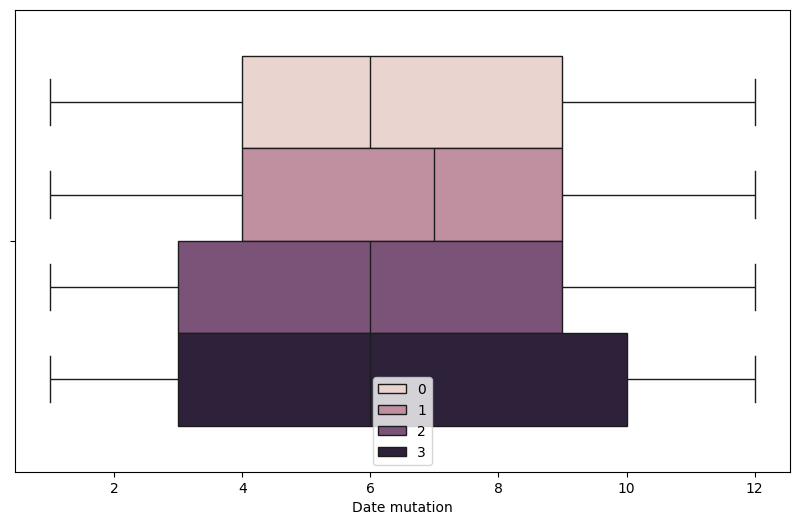

In [58]:
#clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_scaled)
labels = kmeans.labels_

#plot valeur fonciere against sufrace bati
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Valeur fonciere', y='Surface reelle bati', hue=labels, data=df)
plt.ylim(0, 400)
plt.xlim(0, 5000000)
plt.title('Valeur Fonciere vs Surface Réelle Bati')
plt.xlabel('Valeur Fonciere')
plt.ylabel('Surface Réelle Bati')
plt.show()

#boxplot de chaque colonne avec label
plt.figure(figsize=(10, 6))
sns.boxplot(x='Valeur fonciere', data=df, hue=labels)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Surface reelle bati', data=df, hue=labels)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Surface terrain', data=df, hue=labels)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Nombre pieces principales', data=df, hue=labels)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type local', data=df, hue=labels)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Code postal', data=df, hue=labels)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Date mutation', data=df, hue=labels)
plt.show()

## Apprentissage supervisé

### KNN

In [70]:
# Utilisation de KNN en utilisant le label code postal

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Sélection des features et de la cible pour le KNN
X = df_scaled.drop('Code departement', axis=1)
y = df_encoded['Code departement']

# Division des données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation et entrainement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Prédictions
y_pred = knn.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))




Accuracy: 0.49349529952301296
Confusion Matrix:
 [[318  58 145 ...   0   0   0]
 [ 73 318 251 ...   0   0   0]
 [145 194 724 ...   0   0   0]
 ...
 [  0   0   0 ...  86   5  50]
 [  0   0   0 ...  12  17  23]
 [  0   0   0 ...  71  15 279]]
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.25      0.24      1275
           1       0.47      0.42      0.44       754
           2       0.47      0.53      0.49      1376
           3       0.37      0.29      0.33       833
           4       0.58      0.71      0.64      2304
           5       0.55      0.60      0.57      2069
           6       0.26      0.19      0.22       509
           7       0.45      0.49      0.47      1427
           8       0.52      0.57      0.55      2425
           9       0.46      0.50      0.48      1133
          10       0.41      0.24      0.30       896
          11       0.24      0.26      0.25      1529
          12       0.40      0.3

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Sélection des features et de la cible pour le KNN
X = df_scaled.drop('Type local', axis=1)
y = df_encoded['Type local'].astype(int)  # Conversion en entier si nécessaire

# Division des données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation et entrainement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Prédictions
y_pred = knn.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9181160108399501
Confusion Matrix:
 [[  8631     54   6971]
 [    51   9925     51]
 [  3908    175 107135]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.55      0.61     15656
           1       0.98      0.99      0.98     10027
           2       0.94      0.96      0.95    111218

    accuracy                           0.92    136901
   macro avg       0.87      0.83      0.85    136901
weighted avg       0.91      0.92      0.91    136901



### Régression linéaire

Random Forest Mean Squared Error: 0.0004105471583860342
Random Forest R^2 Score: 0.9995961227996725


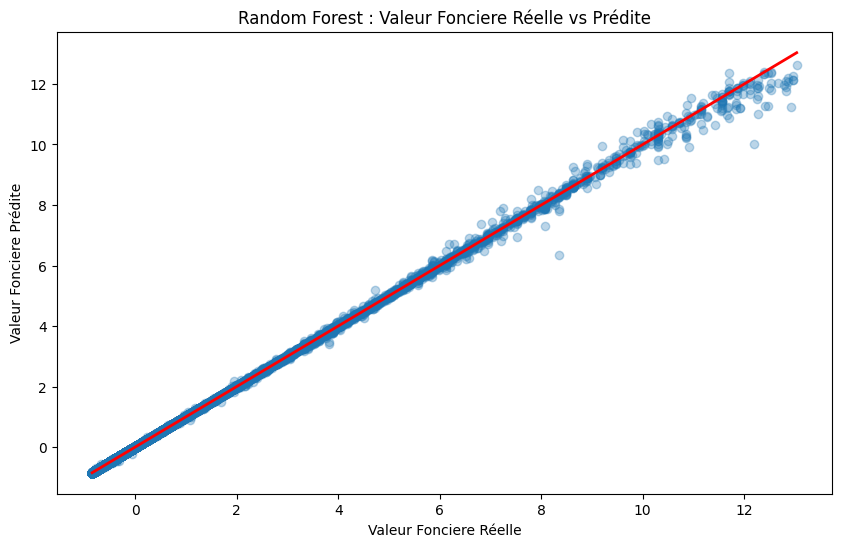

In [61]:
# Utilisation d'une régression linéaire

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Sélection des features et de la cible pour la régression linéaire
X = df_scaled.drop('Valeur fonciere', axis=1)
y = df_scaled['Valeur fonciere']

# Division des données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation et entrainement du modèle de régression linéaire
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Mean Squared Error:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R^2 Score:", r2_score(y_test, y_pred_rf))

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Valeur Fonciere Réelle')
plt.ylabel('Valeur Fonciere Prédite')
plt.title('Random Forest : Valeur Fonciere Réelle vs Prédite')
plt.show()
